# Проект: вариант 2
### Задание 1. A/B–тестирование
#### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

#### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

#### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?

Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

#### 1.4 Требования к ответу

- При выполнении тестового задания необходимо использовать язык программирования Python. 
- В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
- Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.





## Выполнение задания
### Получаем входные данные

In [1]:
# импортруем библиотеки, которые могут понадобиться
import pandas as pd
import numpy as np
import requests
import json
from urllib.parse import urlencode
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# базовый url:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# создадим список с url, с которых будем закачивать данные:
urls = ['https://disk.yandex.ru/d/UhyYx41rTt3clQ',
        'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ',
        'https://disk.yandex.ru/d/pH1q-VqcxXjsVA']

# создадим список такой же длины, в который запишем закачанные датасеты:
datasets=list(range(0,len(urls)))

# цикл проходит по списку urls, закачивает датасеты и записывает их в список:
for i in enumerate(urls):
    url = base_url + urlencode(dict(public_key=i[1]))
    response = requests.get(url)
    download_url = response.json()['href']
    datasets[i[0]] = pd.read_csv(download_url, sep = ';')
       
# достаем датасеты из списка и складываем в переменные с соответствующим названием:   
groups = datasets[0]
active_studs = datasets[1]
checks = datasets[2]

### Исследуем входные данные

#### Таблица groups

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.info() # null-значения отсутствуют, типы данных правильные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [5]:
groups.nunique() # все id уникальны

id     74484
grp        2
dtype: int64

In [6]:
groups.groupby("grp").size() #сколько пользователей в каждой группе. Группы изначально существенно различаются по размеру.

grp
A    14671
B    59813
dtype: int64

#### Важно:
Видим, что изначально пользователи поделены на неравные группы: тестовая группа в 4 раза больше контрольной. Это не самый удачный дизайн эксперимента, так как при неравном делении на группы мы проигрываем в мощности статистических тестов: она будет ниже, чем при делении на равные группы. Либо для достижения необходимой мощности потребуется проводить эксперимент дольше.

#### Таблица active_studs

In [8]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [9]:
active_studs.info() # null-значения отсутствуют, типы данных правильные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [10]:
active_studs.nunique() # все id уникальны

student_id    8341
dtype: int64

#### Таблица checks

In [11]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [12]:
checks.info() # null-значения отсутствуют, типы данных правильные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [13]:
checks.nunique() # все id уникальны

student_id    541
rev            39
dtype: int64

In [14]:
checks.rev.sort_values().unique() # смотрим, какие вообще были суммы. отрицательных и нулевых сумм нет.

array([ 199.    ,  290.    ,  398.    ,  489.    ,  580.    ,  590.    ,
        597.    ,  630.    ,  690.    ,  796.    ,  840.    ,  870.    ,
        880.    ,  990.    , 1039.    , 1050.    , 1140.    , 1160.    ,
       1180.    , 1339.    , 1388.    , 1530.    , 1729.    , 1830.    ,
       1900.    , 1900.0001, 1968.    , 1980.    , 2099.    , 2190.    ,
       2220.    , 2820.    , 2890.    , 2900.    , 2910.    , 3040.    ,
       3260.    , 3660.    , 4650.    ])

In [15]:
checks.groupby('student_id')\
        .agg({'rev':'count'})\
        .rev.unique() # у каждого оплатившего пользователя была ровно одна оплата

array([1])

### Предварительная обработка

Проверим, все ли платящие пользователи попали в список активных. 

Видим, что 149 заплативших в дни эксперимента пользователей не попали в список активных, то есть не заходили на сайт. 

In [16]:
checks.query('student_id not in @active_studs.student_id').student_id.count()

149

Такое возможно, если произошло списание денег по подписке, рассрочке или другим подобным ежемесячным платежам (оформленным ранее, до проведения эксперимента).
В таком случае данные пользователи не участвовали в эксперименте, платежи необходимо удалить из расчета метрик эксперимента.

In [17]:
checks = checks.merge(active_studs) # удаляем платежи "по подписке"
checks.shape

(392, 2)

Проверим, для всех ли активных и платящих пользователей есть данные о принадлежности к А/В группам.

Видим, что не для всех: 13 активных пользователей и 1 платящий пользователь без пометки группы.
Эти данные не получится учесть при расчете метрик по группам А и В. При объединении таблиц эти данные будут отрезаны.

In [18]:
print(active_studs.query("student_id not in @groups.id").student_id.count(), ' активных')
print(checks.query("student_id not in @groups.id").student_id.count(), ' платящих')

13  активных
1  платящих


#### Теперь объединим входные данные в единую таблицу
К таблице groups, которая содержит список пользователей с пометкой их группы, с помощью левого джойна добавим данные по активности студентов и по оплатам.

In [19]:
data = groups.merge(active_studs, how = 'left', left_on = 'id', right_on = 'student_id')\
             .merge(checks, how = 'left', left_on = 'id', right_on = 'student_id')

data = data.rename({'student_id_x':'active', 'student_id_y':'paying'}, axis = 1)

Активных и платящих отметим единицей, избавимся от null.

In [20]:
data['active'] = data['active'].apply(lambda x: 1 if x > 0 else 0)
data['paying'] = data['paying'].apply(lambda x: 1 if x > 0 else 0)
data['rev'] = data['rev'].fillna(0)

#### Отберем только активных пользователей, так как это те пользователи, которые заходили на сайт в дни проведения эксперимента, а значит только они участвовали в эксперименте. 

In [21]:
data = data.query('active == 1').reset_index(drop = True)

In [22]:
data.head()

,id,grp,active,paying,rev
0,1627,A,1,1,990.0
1,2085,B,1,0,0.0
2,2215,B,1,0,0.0
3,3391,A,1,0,0.0
4,3401,B,1,0,0.0


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8328 entries, 0 to 8327
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8328 non-null   int64  
 1   grp     8328 non-null   object 
 2   active  8328 non-null   int64  
 3   paying  8328 non-null   int64  
 4   rev     8328 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 325.4+ KB


In [24]:
data.nunique()

id        8328
grp          2
active       1
paying       2
rev         39
dtype: int64

In [25]:
data.query('paying == 1 and active == 0') # проверка, что теперь среди платящих пользователей нет неактивных

,id,grp,active,paying,rev


### Список метрик 

#### Целевая метрика:
- CR (Conversion Rate) из активного пользователя в покупку

#### Дополнительная метрика:
- ARPU (Average revenue per user) - средний доход на пользователя

#### Справочно:
- ARPPU (Average revenue per paying user) - средний доход на платящего пользователя

#### Пояснение:

<b>Показатель конверсии - целевой</b>, потому что именно он показывает реакцию пользователей на новый дизайн: будут покупать больше или меньше. Какой именно из видов CR?  В эксперименте участвовали только пользователи, зашедшие на сайт, то есть активные пользователи. Поэтому из метрик конверсии показательным является только конверсия из активного пользователя в покупку. 

Также обычно ключевым является показатель среднего дохода с пользователя. Рассмотрим показатели ARPU/ARPPU:

- ARPPU не подходит в качестве целевого, потому что возможны ситуации, когда ARPPU растет, но при этом общий доход падает из-за снижения кол-ва платящих пользователей или кол-ва оплат на пользователя. 
- ARPU более показателен. Нужно ли его считать целевой метрикой ?

Посмотрим на формулу расчета ARPU:

ARPU = CR из активности в покупку * ARPPU = CR из активности в покупку * среднее от (кол-во покупок у платящих пользователей * средний чек пользователя).

Так как в данном эксперименте кол-во покупок у платящих пользователей = 1, то:

ARPU = CR из активности в покупку * ср. чек

Посмотрим на средний чек в контексте задачи: 
1. Была каким-то образом изменена механика оплаты, и неизвестно каким именно. Возможно, была предложена система оплаты в формате подписки, когда в первый месяц пользователь платит больше, чем в последующие. Или наоборот, в первый месяц пользователь платит меньше, чем в последующие. Оба варианта встречаются. И из-за этого месяц, в который совершена покупка, может быть непоказательным: доход искажен в большую или меньшую сторону.

2. Судя по тому, что во входных данных колонки с id обозначены students_id, похоже, что это образовательная платформа. Здравый смысл подсказывает, что средний чек (и вообще чеки) определяется исходя из того, какие курсы интересны пользователям, а не исходя из удобства механики оплаты. Одни курсы дороже, другие курсы дешевле. Одни обширнее, другие короче. Еще меняются тренды на рынке труда, это тоже может повлиять на популярность тех или иных курсов.

<b>С учетом последних двух абзацев окончательное решение о применении ARPU в качестве целевой метрики будет приниматься после обсуждения с коллегами, хорошо знакомыми с бизнесом и нюансами проводимого эксперимента</b>.

### Расчет метрик

In [26]:
# сгруппируем по группам A и B
metrics = data.groupby('grp')\
                .aggregate({'active':'sum', 'paying':'sum', 'rev':'sum'})\

# рассчитаем метрики
metrics['CR_active_to_paying'] = (metrics['paying'] / metrics['active'] * 100).round(2)
metrics['ARPU'] = (metrics['rev'] / metrics['active']).round(1)
metrics['ARPPU'] = (metrics['rev'] / metrics['paying']).round(1) # справочно
metrics['rev'] = metrics['rev'].round(0)

metrics

,active,paying,rev,CR_active_to_paying,ARPU,ARPPU
grp,,,,,,
A,1535,78,72820.0,5.08,47.4,933.6
B,6793,313,393074.0,4.61,57.9,1255.8


#### Главное, что видим по таблице:
- Конверсия из активного пользователя  в покупку (CR_active_to_paying) в тестовой группе ниже по сравнению с контрольной.
- При этом ARPU в тестовой группе выше по сравнению с контрольной (за счет того, что ARPPU выше).

Проверим значимость различий статистически.

### Проверим значимость различий CR из активного пользователя в покупку

In [28]:
metrics['CR_active_to_paying']

grp
A    5.08
B    4.61
Name: CR_active_to_paying, dtype: float64

CR из активного пользователя в покупку = кол-во платящих пользователей / кол-во активных пользователей 

Построим график, отражающий соотношение платящих и неплатящих пользователей по группам. Видим, что визуализация не дает возможности сделать выводы, необходим статистический тест.

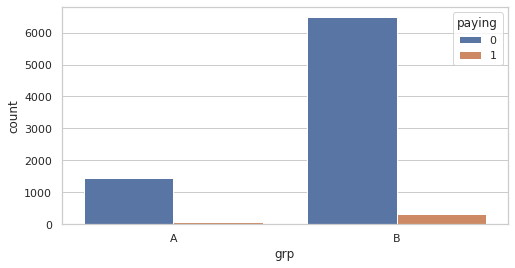

In [29]:
sns.set(rc={'figure.figsize':(8,4)}, style="whitegrid")

sns.countplot(data = data, x = 'grp', hue = 'paying')

Чтобы проверить значимость различий, проведем статистический тест. Так как есть две категориальные переменные (группа пользователя и платящий ли он), то будем использовать тест <b> Хи-квадрат</b>. Определим гипотезы теста:

- 𝐻0: нет взаимосвязи между тем, какая схема оплаты предлагалась пользователям, и конверсией в оплату
- 𝐻1: есть взаимосвязь между тем, какая схема оплаты предлагалась пользователям, и конверсией в оплату

Уровень значимости альфа определим на уровне 0.05.

Я выбираю тест из библитеки pingouin, так он содержит много интересной информации:

In [30]:
pg.chi2_independence(data, x = 'grp', y = 'paying')

(paying            0           1
 grp                            
 A       1462.931676   72.068324
 B       6474.068324  318.931676,
 paying       0      1
 grp                  
 A       1457.5   77.5
 B       6479.5  313.5,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  0.526607  1.0  0.468037  0.007952  0.112168
 1        cressie-read  0.666667  0.523446  1.0  0.469375  0.007928  0.111786
 2      log-likelihood  0.000000  0.517247  1.0  0.472019  0.007881  0.111037
 3       freeman-tukey -0.500000  0.512702  1.0  0.473971  0.007846  0.110488
 4  mod-log-likelihood -1.000000  0.508246  1.0  0.475899  0.007812  0.109950
 5              neyman -2.000000  0.499590  1.0  0.479680  0.007745  0.108905)

#### Интерпретируем результат:

Первая таблица - таблица ожидаемых значений, вторая таблица - таблица наблюдаемых значений.
Далее непосредственно итоги теста. Нас интересует главным образом два показателя pval и power по Пирсону.
- p-value составил около 0.47. Это существенно выше альфа уровня значимости 0.05. Значит мы не можем отклонить нулевую гипотезу. Статистически значимая взаимосвязь группы пользователя с тем, совершил ли он покупку, не подтверждена.
- power - это мощность теста. power = 1 - вероятность совершить ошибку 2 рода. Мы получили очень низкую мощность 0.11, значит вероятность ошибки второго рода около 0.89 (того, что мы не отклоним нулевую гипотезу при реально имеющихся различиях). 

Причина низкой мощности в недостаточном размере групп, чтобы задетектировать полученный эффект. Размер групп определяется исходя из MDE - минимального различия, интересного бизнесу. Полученный эффект оказался ниже, чем заложенный перед стратом эксперимента MDE, а значит обнаруженный эффект не интересен бизнесу - слишком незначителен для нашей компании. 

Второй вариант интерпретации низкой мощности: эксперимент был проведен неправильно, группы набраны недостаточного размера, чтобы обеспечить высокую мощность теста (не менее 0.8).

### Итог статистического теста по CR: 
Конверсия из активного пользователя в покупку (CR_active_to_paying) в тестовой группе ниже по сравнению с контрольной. При этом в ходе статистического теста не удалось отклонить нулевую гипотезу об отсутствии взаимосвязи между тем, какая схема оплаты предлагалась пользователям, и конверсией в оплату. При этом мощность теста оказалась слишком низкой, велика вероятность ошибки 2 рода.

### Проверим значимость различий ARPU (средний доход по активным пользователям)

In [31]:
metrics['ARPU']

grp
A    47.4
B    57.9
Name: ARPU, dtype: float64

Построим график распределения revenue по активным пользователям. По графику видно, что распределение далеко от нормального. Основная масса наблюдений сосредоточена в 0, а остальных значений так мало, что на графике их почти не видно. Распределение по своей форме напоминает tweedie-распределение.

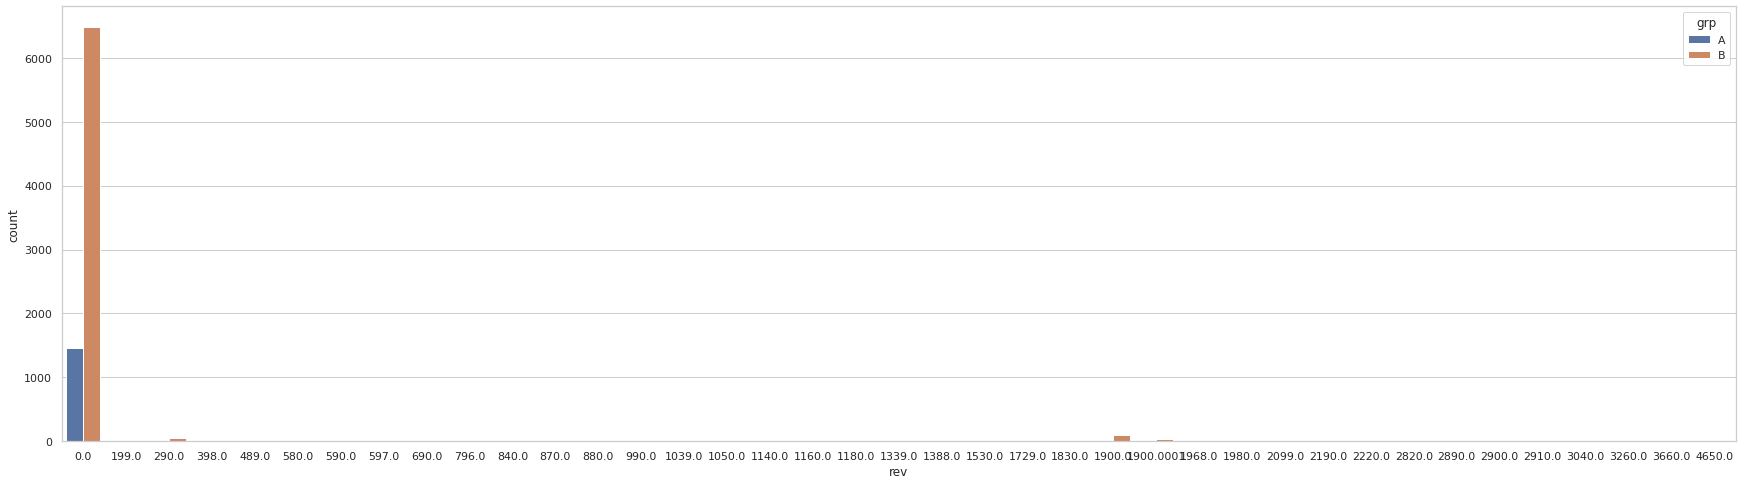

In [32]:
sns.set(rc={'figure.figsize':(30,8)}, style="whitegrid")

sns.countplot(data = data, x = 'rev', hue = 'grp')

Построим qqplot, чтобы проверить нормальность. Очевидно, данные не нормальные в обеих группах.

Text(0.5, 1.0, 'группа B')

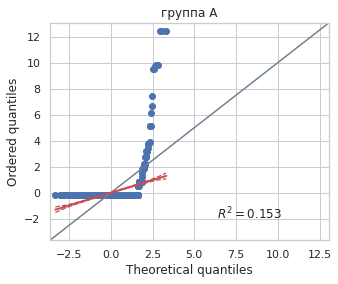

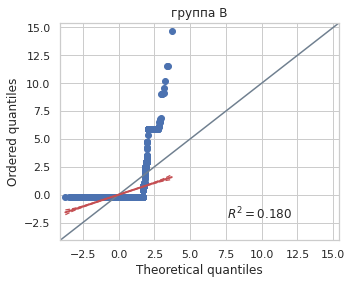

In [33]:
pg.qqplot(data.query("grp == 'A'").rev)
plt.title('группа A')
pg.qqplot(data.query("grp == 'B'").rev)
plt.title('группа B')

#### Проверим нормальность распределения с помощью статистического теста. 
Для этого воспользуюсь тестом из библиотеки pingouin. Определим гипотезы теста:

- 𝐻0: распределение является нормальным
- 𝐻1: распределение не является нормальным

Уровень значимости определим как 0,05.

In [34]:
print(pg.normality(data.query("grp == 'A'").rev, method='normaltest'), ' для группы А')
print(pg.normality(data.query("grp == 'B'").rev, method='normaltest'), ' для группы B')

               W  pval  normal
rev  2235.003893   0.0   False  для группы А
               W  pval  normal
rev  7799.583992   0.0   False  для группы B


p-value для обоих групп меньше, чем 0,05. Следовательно, мы можем отклонить нулевую гипотезу. Распределение в обоих группах не является нормальным.

#### Проверим различия в дисперсиях групп с помощью статистического теста Левена.
- 𝐻0: дисперсии в группах не различаются
- 𝐻1: дисперсии в группах различаются

Уровень значимости определим как 0,05.

In [35]:
pg.homoscedasticity(data, dv="rev", group="grp")

,W,pval,equal_var
levene,1.423391,0.23288,True


p-value больше, чем уровень значимости 0,05. Значит мы не можем отклонить нулевую гипотезу, дисперсии в группах не различаются.

#### Проверим различие в средних (различие в метрике ARPU) с помощью т-теста
Для проведения т-теста должны выполняться 2 условия:  
1. Дисперсии внутри групп должны быть примерно одинаковы (требование гомогенности дисперсий)
2. Распределение в обоих группах должно быть нормальным

Требование гомогенности дисперсий выполняется. Требование нормальности распределений не выполняется. Однако, у нас большие размеры групп (кол-во наблюдение существенно выше 30), значит распределение средних стремится к нормальному. Это позволяет использовать т-тест.

Определим гипотезы теста:

- 𝐻0: различия между ARPU нет
- 𝐻1: различие между ARPU есть

Уровень значимости определим как 0,05.

In [36]:
pg.ttest(data.query("grp == 'A'").rev, data.query("grp == 'B'").rev)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.250311,2406.43932,two-sided,0.211308,"[-26.77, 5.93]",0.033717,0.069,0.222337


#### Интерпретация результатов тестa:
p-value больше, чем уровень значимости 0,05. Значит мы не можем отклонить нулевую гипотезу, статистически значимого различия между ARPU в тестовой и контрольной группах не выявлено. Однако при этом pingouin дает информацию о низкой мощности теста. Она равна 0.22, значит ошибка второго рода очень высока 0.78. Возможные причины этого написаны выше (см. интерпретацию результата теста по CR).

### Итог статистического теста по ARPU: 
ARPU в тестовой группе выше по сравнению с контрольной. При этом в ходе статистического теста (т-теста) не удалось отклонить нулевую гипотезу об отсутствии различий между ARPU в тестовой и контрольной группах, значит cтатистически значимого различия между ARPU в тестовой и контрольной группах не выявлено. При этом мощность теста оказалась очень низкой, велика вероятность ошибки 2 рода.

### Общие итоги эксперимента

#### По итогу эксперимента мы имеем следующие метрики:

In [37]:
metrics[['CR_active_to_paying','ARPU']]

,CR_active_to_paying,ARPU
grp,,
A,5.08,47.4
B,4.61,57.9


In [38]:
#Рассчитаем различия метрик в относительном выражении:

CR_growth =np.round((metrics.CR_active_to_paying.loc['B']/metrics.CR_active_to_paying.loc['A']-1)*100, 1)
ARPU_growth =np.round((metrics.ARPU.loc['B']/metrics.ARPU.loc['A']-1)*100, 1)

print(CR_growth, ARPU_growth)

-9.3 22.2


#### Получили следующие различия метрик:

- CR из активного пользователя в покупку: в тестовой группе -9.3% по сравнению с контрольной. Различия не оказались статистически значимыми (проведен тест хи-квадрат). При этом тест показал низкую мощность.

- ARPU : в тестовой группе +22.2% по сравнению с контрольной. Различия не оказались статистически значимыми (проведен т-тест). При этом тест показал низкую мощность.

#### Выводы:

Целевая метрика "CR из активности в покупку" не отличается значимо в двух группах, при этом вектор ее изменения - на снижение в тестовой группе по сравнению с контрольной. Мощность теста получена низкая, это значит что:
- либо в изначальный дизайн теста был заложен MDE больший, чем полученный эффект, значит для компании полученный эффект неинтересен
- либо неправильный дизайн эксперимента: недостаточный объем групп, чтобы подтвердить значимость различий

В обоих случаях <b>механику оплаты менять не надо</b>.

По поводу ARPU необходима информация от коллег - стоит ли считать метрику ARPU целевой или нет (мои сомнения на эту тему изложены выше на этапе выбора целевой метрики, мною она не принята целевой). Возможно, коллеги подтвердят, что да - ARPU надо рассматривать в качестве целевой метрики. Тогда мы упираемся в то, что в ходе статистического теста положительные изменения не оказались статистически значимыми, значит раскатывать механику на всех не надо. 